In [2]:
!pip install camb

  Using cached camb-1.5.2-py3-none-any.whl


In [10]:
import camb
from tqdm import tqdm
from numpy import random
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

def define_plot_resolution():
    fig = plt.gcf()

    DPI = fig.get_dpi()
    fig.set_size_inches(12, 8)
    ax = plt.gca()
    for tickLabel in ax.get_xticklabels()+ax.get_yticklabels():
        tickLabel.set_fontsize(22)
    ax.yaxis.label.set_size(22)
    ax.xaxis.label.set_size(22)
    ax.yaxis.offsetText.set_fontsize(22)
    ax.xaxis.offsetText.set_fontsize(22)
    return



clth = np.load("ILC/clth_all.npy")
#clth = [np.load("ILC/clth.npy"), np.load("ILC/clth.npy")]



# start from some cls

### start from generated maps

In [11]:
wn = False
uncorr_noise = False
nside = 16
lmax = 2*nside-1
n = 100

if wn or uncorr_noise: 
    
    a, b = [], []
    Nl = 1e-15
    #Nl = 5e-17
    Nlist = [0,0,8.24210362e-29, 9.30808618e-29, 5.62311271e-29, 1.39542146e-29, 6.84661070e-30, 1.97876356e-30, 5.59465589e-31, 3.81845934e-31, 1.09979329e-31, 7.79599790e-32, 3.58107838e-32, 3.40179117e-32, 1.41515158e-32, 1.33816492e-32, 1.11602516e-32, 8.73161353e-33, 3.81183927e-33, 7.94311674e-33, 4.76081826e-33, 6.10950817e-33, 7.41193229e-33, 8.23192005e-33, 6.29229343e-33, 7.35708027e-33, 9.49522952e-33, 8.77978459e-33, 1.03355956e-32, 1.18377414e-32, 1.37288297e-32, 2.17268138e-32, 2.32661500e-32, 3.26887620e-32, 4.65466529e-32, 5.76149719e-32, 7.25617261e-32, 1.28537793e-31, 1.37839162e-31, 5.49543942e-31, 9.10350501e-31, 1.55059302e-30, 3.47200128e-30, 1.34389650e-29, 2.92970625e-29, 1.54432033e-28, 4.56873553e-28, 1.49724746e-26,]
    Nlist = np.sqrt(np.array(Nlist[:lmax+1]))/np.sqrt(2/(2*np.arange(0,lmax+1)+1))

    #Nl = 0

    N = np.sqrt(Nl*(12*nside**2)/(4*np.pi))

    glat = 0
    t, p = hp.pix2ang(nside, range(hp.nside2npix(nside)))
    mask = np.ones(hp.nside2npix(nside))
    mask[abs(90 - np.rad2deg(t)) < glat] = 0
    #mask = hp.smoothing(mask, 20/180*np.pi)
    fsky = np.sum(mask)/len(mask)
    #hp.mollview(mask)
    print(fsky)
    
    for i in tqdm(range(n)):
        mapi = hp.synfast(clth[1], nside = nside, new=True)
        if wn:
            n1 = N*random.randn(12*nside**2)
            n2 = N*random.randn(12*nside**2)
        if uncorr_noise: 
            n1 = hp.synfast(Nlist, nside = nside, new=True)
            n2 = hp.synfast(Nlist, nside = nside, new=True)        
        k = mapi+n1
        l = mapi+n2
        a.append(hp.anafast(k*mask)[:lmax+1])
        b.append(hp.anafast(k*mask, l*mask)[:lmax+1])

    a = np.array(a)/fsky ; b = np.array(b)/fsky



### start from generated cls

In [12]:
corr_noise = False

if corr_noise:
    b = []
    for i in tqdm(range(n)):
        mapi = hp.synfast(clth[1], nside = nside, new=True)
        b.append(hp.anafast(mapi)[:lmax+1])
        #b.append(clth[1,0:lmax+1])
    b = np.array(b)
    #random.seed(1)
    corr = random.multivariate_normal(len(M)*[0], M, size = (100))
    b = b+np.concatenate((np.array([[0,0] for i in range(100)]).T, corr.T)).T


/tmp/ipykernel_315/2449248115.py:3: RuntimeWarning: invalid value encountered in divide
  b = np.concatenate((np.array([[0,0] for i in range(100)]).T,


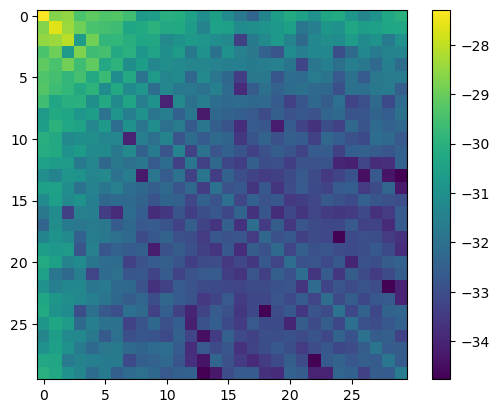

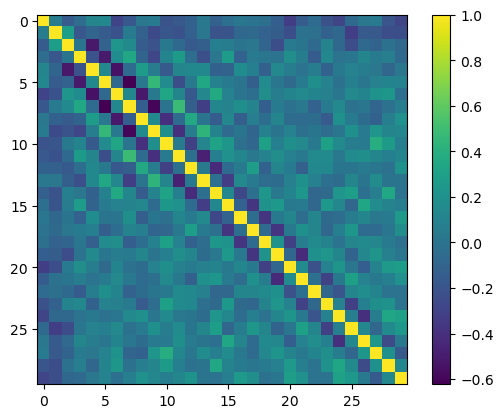

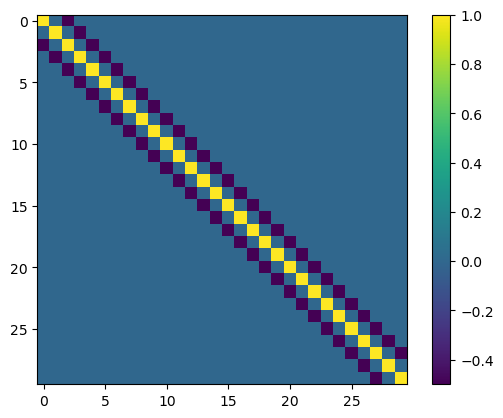

100%|██████████| 100/100 [00:00<00:00, 659481.76it/s]


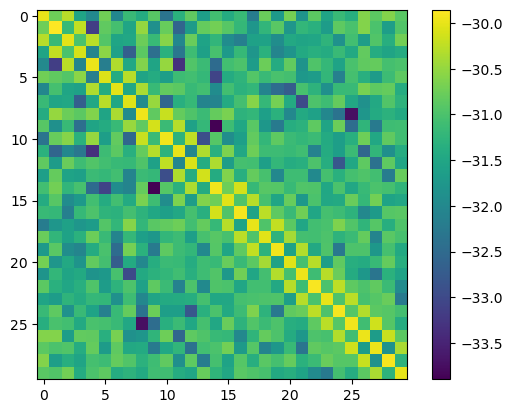

In [70]:
corr_noise = True

b = np.concatenate((np.array([[0,0] for i in range(100)]).T,
                    np.load(f'ILC/EBsp/allclE40.npy')[:,:lmax-1].T)).T\
            /(np.arange(0, lmax+1)*(np.arange(0, lmax+1)+1)/(2*np.pi)*1e12)
z=b
M = np.cov((z[:,2:] - C_fid).T)

plt.figure()
#plt.imshow(np.log10(np.abs(M)))
plt.imshow(np.log10(np.abs(M)))
plt.colorbar()
plt.show()

plt.figure()
#plt.imshow(np.log10(np.abs(M)))
plt.imshow(np.einsum('i,ij,j->ij',(1/np.sqrt(np.diag(M))),M,(1/np.sqrt(np.diag(M)))))
plt.colorbar()
plt.show()

my_corr = np.identity(len(M))
for i in range(len(M)-2): 
    my_corr[i, i+2] = -0.5 # 0
    my_corr[i+2, i] = -0.5 # 0
plt.figure()
plt.imshow(my_corr)
plt.colorbar()
plt.show()

#my_cov = np.einsum('i,ij,j->ij',(np.sqrt(np.diag(M))),my_corr,(np.sqrt(np.diag(M))))
my_cov = 1e-30*my_corr
b = []
for i in tqdm(range(n)):
    #mapi = hp.synfast(clth[1], nside = nside, new=True)
    #b.append(hp.anafast(mapi)[:lmax+1])
    b.append(clth[1, 0:lmax+1])
corr = random.multivariate_normal(len(my_cov)*[0],my_cov, size = (100))
b = np.array(b)+np.concatenate((np.array([[0,0] for i in range(100)]).T, corr.T)).T

plt.figure()
plt.imshow(np.log10(np.abs(np.cov(b[:,2:].T))))
plt.colorbar()
plt.show()

### start from my cls

In [71]:
my_cl = False

if my_cl:
    b = np.concatenate((np.array([[0,0] for i in range(100)]).T,
                        np.load(f'ILC/EBsp/allclE40.npy')[:,:lmax-1].T)).T\
                /(np.arange(0, lmax+1)*(np.arange(0, lmax+1)+1)/(2*np.pi)*1e12)
    z=b
    M = np.cov((z[:,2:] - C_fid).T)
    
    plt.figure()
    plt.imshow(np.log10(np.abs(M)))
    plt.colorbar()
    plt.show()


# plot the cls

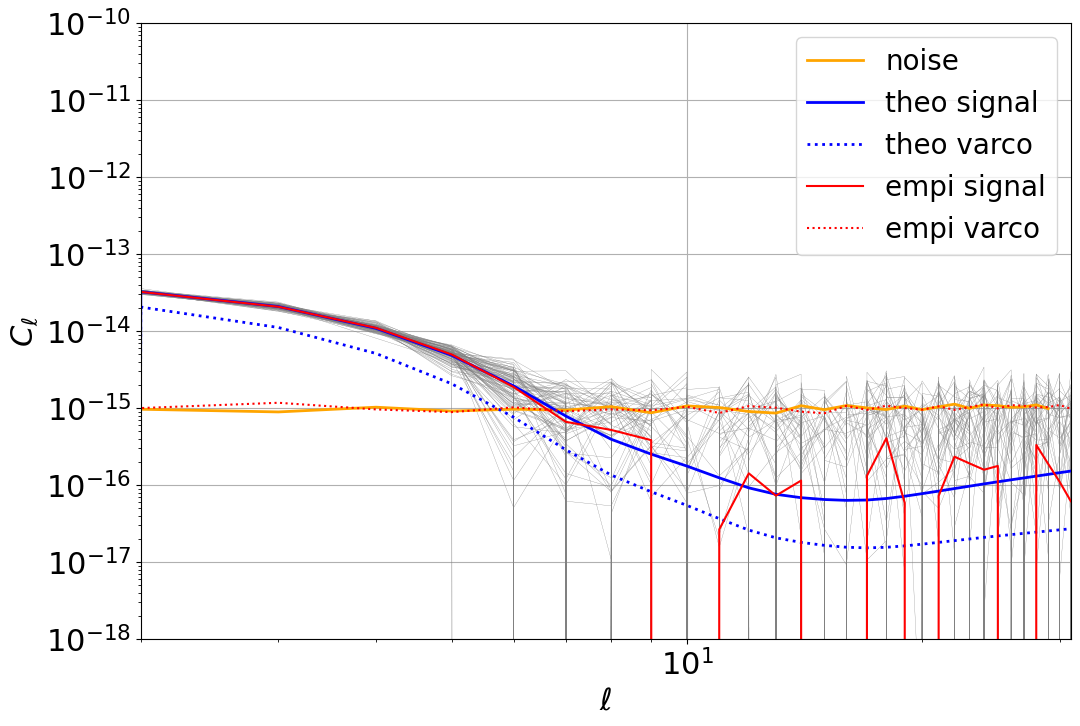

In [98]:
#z = a
#plt.figure(figsize = (10,8))
#for i in range(n): plt.plot(z[i], color='gray', lw = 0.2)
#if wn: plt.plot([2, 97], [Nl, Nl], label = 'wn', color = 'orange', lw = 2, ls = '-')
#else: plt.plot(Nlist, label = 'noise', color = 'orange', lw = 2, ls = '-')
#plt.plot(clth[1], label = 'theo signal', lw = 2, color = 'blue', ls = '-')
#plt.plot(np.sqrt(2/(2*np.arange(0, 4001, 1)+1))*clth[1], label = 'theo varco', color = 'blue', lw = 2, ls = ':')
#
#plt.plot(np.mean(z, axis = 0), label = 'empi signal', ls = '-', color = 'red')
#plt.plot(np.std(z, axis = 0), label = 'empi varco', ls = ':', color = 'red')
#plt.grid()
#plt.loglog()
#plt.legend(fontsize = 20)
#plt.xlim(2, lmax)
#plt.ylim(1e-18, 1e-10)
#plt.ylabel(r'$C_\ell$')
#plt.xlabel(r'$\ell$')
#define_plot_resolution()


z = b
plt.figure(figsize = (10,8))
for i in range(n): plt.plot(z[i], color='gray', lw = 0.2)
if wn: plt.plot([2, 97], [Nl, Nl], label = 'wn', color = 'orange', lw = 2, ls = '-')
if uncorr_noise: plt.plot(Nlist*np.sqrt(2/(2*np.arange(0,lmax+1)+1)), label = 'noise', color = 'orange', lw = 2, ls = '-')
if corr_noise: plt.plot(np.sqrt(np.diag(M)), label = 'noise', color = 'orange', lw = 2, ls = '-')
plt.plot(clth[1], label = 'theo signal', lw = 2, color = 'blue', ls = '-')
plt.plot(np.sqrt(2/(2*np.arange(0, 4001, 1)+1))*clth[1], label = 'theo varco', color = 'blue', lw = 2, ls = ':')

plt.plot(np.mean(z, axis = 0), label = 'empi signal', ls = '-', color = 'red')
plt.plot(np.std(z, axis = 0), label = 'empi varco', ls = ':', color = 'red')

plt.loglog()
plt.grid()
plt.legend(fontsize = 20)
plt.xlim(2, lmax)
plt.ylim(1e-18, 1e-10)
plt.ylabel(r'$C_\ell$')
plt.xlabel(r'$\ell$')
define_plot_resolution()

In [99]:
print(str(round(np.sum(z<0)/np.sum(z>-1e3)*100, 1))+'% are negative')

35.0% are negative



# Bias in cross spectra : 0

/tmp/ipykernel_315/2830272818.py:2: RuntimeWarning: invalid value encountered in divide
  for i in range(n): plt.plot((z[i]-clth[1,:lmax+1])/np.std(z, axis = 0), color='gray', lw = 0.2)
/tmp/ipykernel_315/2830272818.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot((np.mean(z, axis = 0)-clth[1,:lmax+1])/np.std(z, axis = 0)*10, label = r'$\frac{<C_\ell>-in}{\sigma_\ell}*\sqrt{N_{sim}}$', ls = '-', color = 'red')


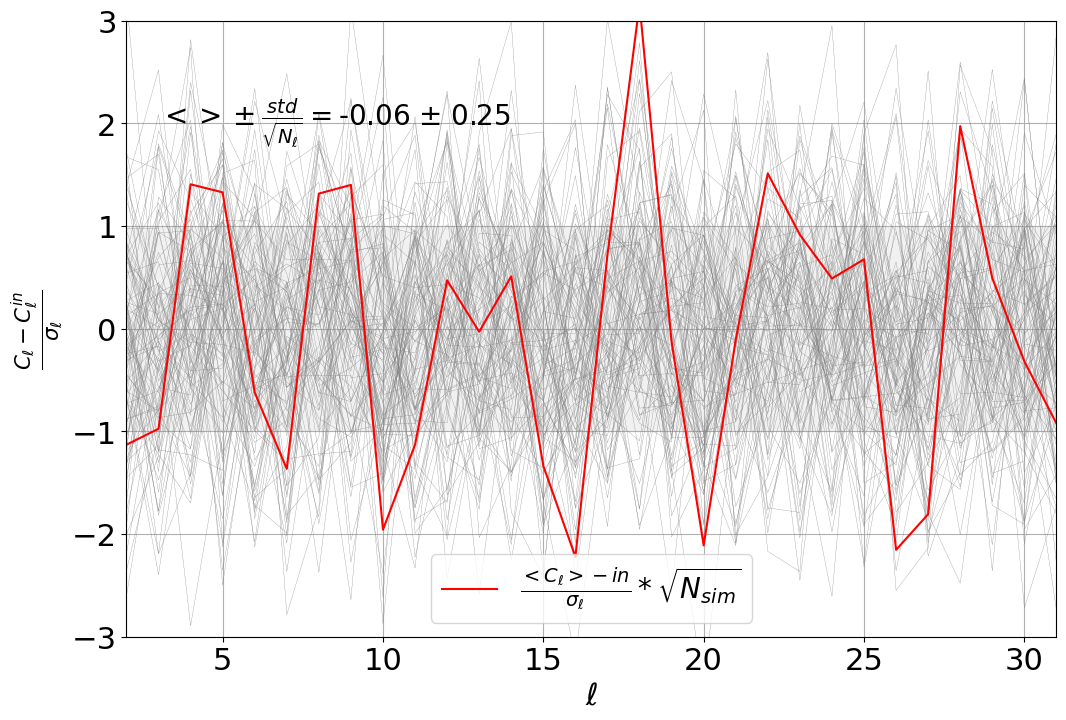

In [100]:
plt.figure(figsize = (10,8))
for i in range(n): plt.plot((z[i]-clth[1,:lmax+1])/np.std(z, axis = 0), color='gray', lw = 0.2)
plt.plot((np.mean(z, axis = 0)-clth[1,:lmax+1])/np.std(z, axis = 0)*10, label = r'$\frac{<C_\ell>-in}{\sigma_\ell}*\sqrt{N_{sim}}$', ls = '-', color = 'red')
plt.axhspan(-1, 1, color = 'lightgray', alpha=0.3)
plt.legend(fontsize = 20)
plt.xlim(2, lmax)
plt.ylim(-3, 3)
plt.grid()

chi = np.sum((np.mean(z, axis = 0)[2:]-clth[1,2:lmax+1])/np.std(z, axis = 0)[2:]*10/np.sqrt(len(z[0,2:])))
chi2 = np.sum((np.mean(z, axis = 0)[2:]-clth[1,2:lmax+1])**2/np.std(z, axis = 0)[2:]**2*100/len(z[0,2:]))
#pvalue = np.sum((np.mean(z, axis = 0)-clth[1,:lmax+1])**2/np.std(z, axis = 0)**2*100/len(z[0]))
mean_bias = np.mean((np.mean(z, axis = 0)[2:]-clth[1,2:lmax+1])/np.std(z, axis = 0)[2:]*10)
err_bias = np.std((np.mean(z, axis = 0)[2:]-clth[1,2:lmax+1])/np.std(z, axis = 0)[2:]*10)/np.sqrt(len(z[0,2:]))

plt.text(3, 1.5, s = ''+
         r'$<>\pm \frac{std}{\sqrt{N_{\ell}}}=$'+f'{round(mean_bias, 2)}'+r' $\pm$ '+ f'{round(err_bias,2)}'+'\n' +
         #r'$\frac{1}{\sqrt{N_{\ell}}}\sum_{\ell}\sqrt{N_{sim}}\frac{<C_\ell>-C_{\ell}^{in}}{\sigma_\ell}=$'+f'{round(chi, 2)}'+'\n' +
         #r'$\frac{1}{N_{\ell}}\sum_{\ell}\left(\sqrt{N_{sim}}\frac{<C_\ell>-C_{\ell}^{in}}{\sigma_\ell}\right)^2=$'+f'{round(chi2, 2)}' +
         '',
         fontsize = 20)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\frac{C_\ell-C_\ell^{in}}{\sigma_\ell}$')
define_plot_resolution()
plt.show()


# OHL

In [101]:
import numpy as np
from iminuit import Minuit

cls = z[:,2:]
fsky = 100

def Cl_th(As, ns, H0, ombh2, omch2, tau, lmax, mode = 1):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, tau=tau)
    pars.InitPower.set_params(As=As, ns=ns)
    results = camb.get_results(pars)
    cl = results.get_total_cls(lmax, CMB_unit='muK', raw_cl=True)*1e-12
    return cl.T[mode, 2:lmax+1]

l = np.arange(2, lmax+1)
Cl2Dl = (l*(l+1)/(2*np.pi)*1e12)
#clth = np.load('ILC/clth.npy')/Cl2Dl
C_fid = clth[1,2:lmax+1]#Cl_th(2e-9, 0.9665, 67.5, 0.022, 0.122, 0.06, l[-1])
ombh2, omch2, H0, ns, As, tau_input  = 0.02237, 0.12, 67.36, 0.965, 2.099e-09, 0.0544
Aseminus2tau = As*np.exp(-2*tau_input)

def compute_offsets(ell, varcl, clref, fsky=1.0, iter=10):
    #print(np.shape(varcl), np.shape(ell), np.shape(clref))
    Nl = np.sqrt(np.abs(varcl - (2.0 / (2.0 * ell + 1) * clref ** 2) / fsky))
    for i in range(iter):
        Nl = np.sqrt(np.abs(varcl - 2.0 / (2.0 * ell + 1) / fsky * (clref ** 2 + 2.0 * Nl * clref)))
    return Nl * np.sqrt((2.0 * ell + 1) / 2.0) # !!!!!!!!!!!!!!!!!!!! the 2 to remove

DeltaC = np.var(cls, axis = 0)
O = compute_offsets(np.arange(2, lmax+1, 1), DeltaC, C_fid, fsky=fsky, iter=10)
#O = 0
g = lambda x : np.sign(x-1)*np.sqrt(2*(np.abs(x)-np.log(np.abs(x))-1))

def OHL_log_lklhd(l, Cmeas, Cfid, O, Minv, ns, H0, ombh2, omch2, tau, Aseminus2tau):
    As = np.exp(2*tau)*Aseminus2tau
    C_th = Cl_th(As, ns, H0, ombh2, omch2, tau, l[-1])
    X = (Cfid+O)*g((Cmeas+O)/(C_th+O))
    return np.einsum('l,lk,k->', X, Minv, X)

M = np.cov((z[:,2:] - C_fid).T)# = np.cov((all_clx).T)
#M = np.diag(np.diag(M))
#M = np.cov((z[:,2:]).T)# = np.cov((all_clx).T)
#Minv = np.linalg.inv(M)
h = (len(z[:,2:]) - len(l) - 2) / (len(z[:,2:]) - 1)
Minv = h * np.linalg.inv(np.cov((z[:,2:] - C_fid).T))

def minuit(cl):
    initial_value = 0.05
    m = Minuit(lambda x : OHL_log_lklhd(l, cl, C_fid, O, Minv, ns, H0, ombh2, omch2, x, Aseminus2tau),
               x=initial_value)
    m.migrad()
    m.minos()
    a, b, c = m.values['x'], -m.merrors['x'].lower, m.merrors['x'].upper
    #print(OHL_log_lklhd(l, cl, C_fid, O, Minv, ns, H0, ombh2, omch2, a + b, Aseminus2tau) - OHL_log_lklhd(l, cl, C_fid, O, Minv, ns, H0, ombh2, omch2, a, Aseminus2tau))
    #print(OHL_log_lklhd(l, cl, C_fid, O, Minv, ns, H0, ombh2, omch2, a + c, Aseminus2tau) - OHL_log_lklhd(l, cl, C_fid, O, Minv, ns, H0, ombh2, omch2, a, Aseminus2tau))
    return a, b, c


In [102]:
nsp = 20
opt_list, low_list, up_list = [], [], []
for cl in tqdm(cls[:nsp]):
    opt, low, up = minuit(cl)
    opt_list.append(opt); low_list.append(low); up_list.append(up)


100%|██████████| 20/20 [00:55<00:00,  2.77s/it]


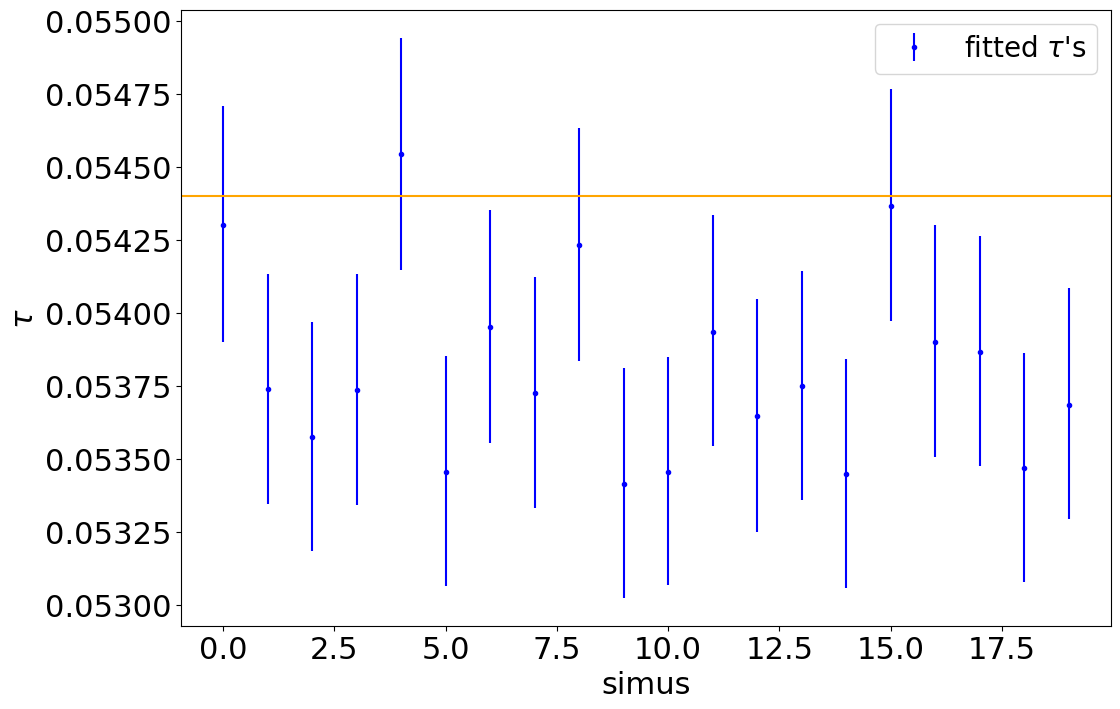

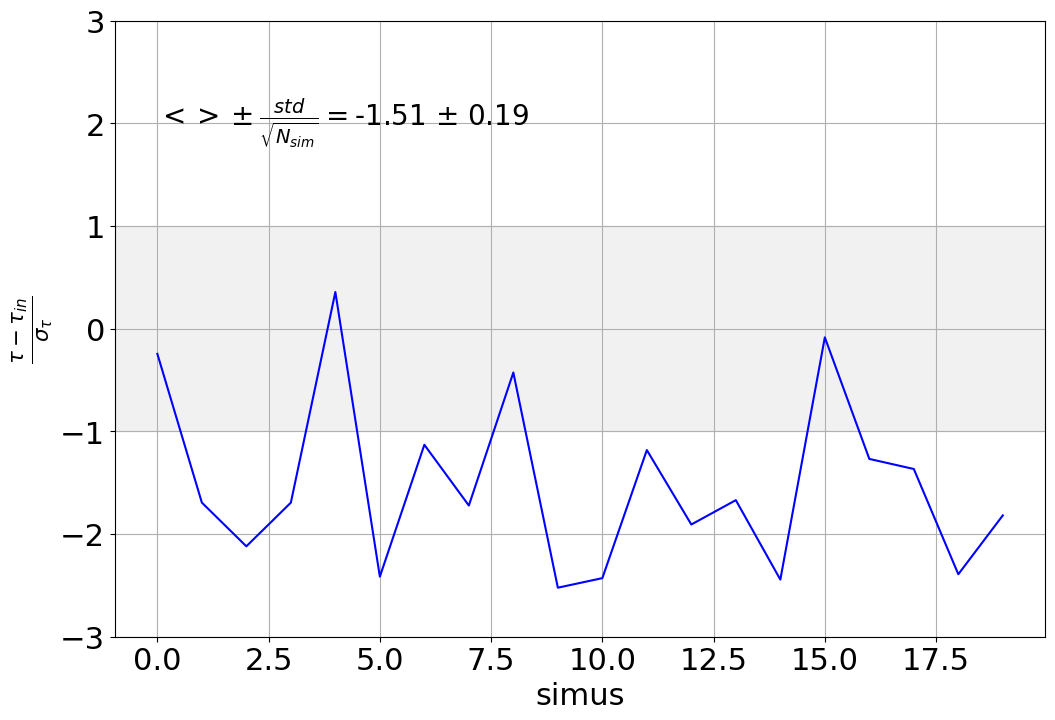

In [103]:
plt.figure()
for i in range(len(cls[:nsp])): plt.errorbar(i, opt_list[i], [[low_list[i]], [up_list[i]]], fmt = '.', color = 'blue')
plt.errorbar([], [], [[]], fmt = '.', color = 'blue', label = r"fitted $\tau$'s")
plt.axhline(tau_input, color='orange')

#chi = np.sum(((np.array(opt_list) - tau_input) / np.array(low_list)/np.sqrt(len(cls[:nsp]))))
#print((np.array(opt_list) - tau_input)/np.array(low_list))

#plt.text(0, 0.0595, s = ''+
#         #r'$\frac{<\tau>-\tau_{in}}{\sqrt{N_{sim}}\tau_{in}}$'+f' = {round(100*(np.mean(opt_list) - tau_input)/(np.sqrt(len(cls))*tau_input), 2)}%\n'+
#         #r'$\frac{<\tau>-\tau_{in}}{\tau_{in}}$'+ f' = {round(100*(np.mean(opt_list) - tau_input)/(tau_input), 2)}%\n'+
#         #r'$\frac{<std(\tau)>}{\tau_{in}}$'+f' = {round(100*np.mean(low_list+up_list)/tau_input, 2)}%\n'+
#         #r'$\frac{\chi^2}{N_{sim}}$='+f'{round(chi2, 2)}' +
#         r'$\frac{\chi}{sqrt(N_{sim})}$='+f'{round(chi, 2)}' +
#         '',
#         fontsize = 20)

plt.legend(fontsize=20) 
define_plot_resolution()
plt.ylabel(r'$\tau$')
plt.xlabel('simus')
plt.show()

plt.figure()
#for i in range(len(cls[:nsp])): 
plt.plot(list(range(len(opt_list))), (np.array(opt_list)-tau_input)/np.array(low_list), color = 'blue')
define_plot_resolution()
plt.ylabel(r'$\frac{\tau-\tau_{in}}{\sigma_\tau}$')
plt.axhspan(-1, 1, color = 'lightgray', alpha=0.3)
plt.grid()
chi2 = np.sum((np.array(opt_list)-tau_input)**2/np.array(low_list)**2)/len(cls[:nsp])
chi = np.sum((np.array(opt_list)-tau_input)/np.array(low_list))/np.sqrt(len(cls[:nsp]))#np.sqrt(len(cls))
mean_bias = np.mean((np.array(opt_list)-tau_input)/np.array(low_list))#np.sqrt(len(cls))
err_bias = np.std((np.array(opt_list)-tau_input)/np.array(low_list))/np.sqrt(len(cls[:nsp]))

plt.text(0, 1.5, s = ''+
         #r'$\frac{<\tau>-\tau_{in}}{\sqrt{N_{sim}}\tau_{in}}$'+f' = {round(100*(np.mean(opt_list) - tau_input)/(np.sqrt(len(cls))*tau_input), 2)}%\n'+
         #r'$\frac{<\tau>-\tau_{in}}{\tau_{in}}$'+ f' = {round(100*(np.mean(opt_list) - tau_input)/(tau_input), 2)}%\n'+
         #r'$\frac{<std(\tau)>}{\tau_{in}}$'+f' = {round(100*np.mean(low_list+up_list)/tau_input, 2)}%\n'+
         r'$<>\pm \frac{std}{\sqrt{N_{sim}}}=$'+f'{round(mean_bias, 2)}'+r' $\pm$ '+ f'{round(err_bias,2)}'+'\n' +
         #r'$\frac{1}{\sqrt{N_{sim}}}\sum_{sim}\frac{\tau-\tau_{in}}{\sigma_\tau}=$'+f'{round(chi, 2)}'+'\n' +
         #r'$\frac{1}{N_{sim}}\sum_{sim}\left(\frac{\tau-\tau_{in}}{\sigma_\tau}\right)^2=$'+f'{round(chi2, 2)}' +
         '',
         fontsize = 20)
plt.ylim(-3, 3)

plt.xlabel('simus')
plt.show()


# Bon fiducial

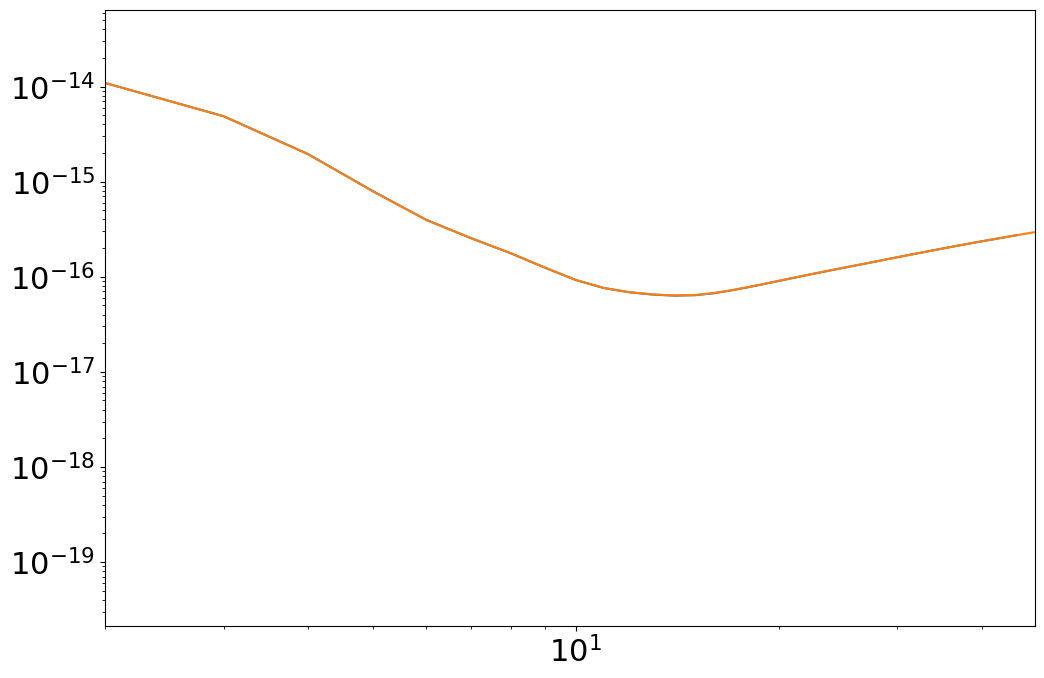

In [276]:
plt.plot(Cl_th(As, ns, H0, ombh2, omch2, tau_input, 47))
plt.plot(clth[1,2:])
plt.loglog()
plt.xlim(2, 48)
define_plot_resolution()

